In [1]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/6/6d/Nvidia_image_logo.svg/200px-Nvidia_image_logo.svg.png" width="90px" align="right" style="margin-right: 0px;">

# Mixed Precision Training of CNN

## Overview

In this example, we will speed-up the training of a simple CNN with mixed precision to perform image classification on the CIFAR10 dataset.

By using mixed precision, we can reduce the training time without a significant impact on classification accuracy. For example, using the NVIDIA Tesla T4 GPU on Google Colab, we can reduce the training time (using the same model and batch size) over 10 epochs from about 600 seconds (FP32) to about 300 seconds with mixed precision, without sacrificing classification accuracy.

**How mixed precision works**

**Mixed precision** is the use of both float16 and float32 data types when training a model.

Performing arithmetic operations in float16 takes advantage of the performance gains of using lower precision hardware (such as Tensor Cores). Due to the smaller representable range of float16, performing the entire training with float16 tensors can result in underflow and overflow errors.

However, *performing only certain arithmetic operations* in float16 results in performance gains when using compatible hardware accelerators, decreasing training time and reducing memory usage, typically without sacrificing model performance.

To learn more about mixed precision and how it works:

* [Overview of Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision)
* [NVIDIA Mixed Precision Training Documentation](https://docs.nvidia.com/deeplearning/sdk/mixed-precision-training/index.html)
* [NVIDIA Deep Learning Performance Guide](https://docs.nvidia.com/deeplearning/sdk/dl-performance-guide/index.html)
* [Information about NVIDIA Tensor Cores](https://developer.nvidia.com/tensor-cores)
* [Post on TensorFlow blog explaining Automatic Mixed Precision](https://medium.com/tensorflow/automatic-mixed-precision-in-tensorflow-for-faster-ai-training-on-nvidia-gpus-6033234b2540)

Do note that some of the resources above reference may an older version of the mixed precision API (setting the `TF_ENABLE_AUTO_MIXED_PRECISION` environment variable). The method presented in this notebook is the current API used in TensorFlow 1.14 and newer.

## Setup and Requirements

**Hardware requirements**

* NVIDIA Tensor Core GPU (Compute Capability >= `7.0`)

**Software requirements**

* TensorFlow version >= `1.14.0-rc0`

The following section will import the necessary libraries and check if these requirements are met.

In [2]:
import time
import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [3]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
if check_tensor_core_gpu_present():
    pass
else:
    !nvidia-smi
    assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.14.0
Tensor Core GPU Present: True


## Import the Dataset

Import the CIFAR10 image dataset from `tf.keras.datasets`

In [4]:
# The data, split between train and test sets

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

num_classes = np.max(y_train) + 1

# Convert class vectors to binary class matrices

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 4s 0us/step


Preprocess the images by scaling the values from the range `0 ~ 255` to the range `0 ~ 1`

In [5]:
def normalize(ndarray):
    ndarray = ndarray.astype("float32")
    ndarray = ndarray/255.0
    return ndarray

x_train = normalize(x_train)
x_test = normalize(x_test)

## Define the Model

Define a reusable helper function to return a simple CNN

In [6]:
def create_model(num_classes=10):
    """
    Returns a simple CNN suitable for classifiying images from CIFAR10
    """
    # model parameters
    act = "relu"
    pad = "same"
    ini = "he_uniform"
    
    model = tf.keras.models.Sequential([
        Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini,
               input_shape=(32,32,3)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        Conv2D(128, (3, 3), activation=act, padding=pad, kernel_initializer=ini),
        MaxPooling2D(pool_size=(4,4)),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(rate=0.2),
        Dense(num_classes, activation="softmax")
    ])

    return model

In [7]:
model = create_model(num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       5

## Training the Model

Train and benchmark the same model trained with and without mixed precision

In [8]:
# training parameters
BATCH_SIZE = 320
N_EPOCHS = 10
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.5)

In [9]:
def train_model(mixed_precision, optimizer):
    """
    Trains a CNN to classify images on CIFAR10,
    and returns the training and classification performance
    
    Args:
        mixed_precision: `True` or `False`
        optimizer: An instance of `tf.keras.optimizers.Optimizer`
    """
    model = create_model(num_classes)

    if mixed_precision:
        import tensorflow
        optimizer = tensorflow.compat.v1.train.experimental.enable_mixed_precision_graph_rewrite(optimizer)

    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    
    train_start = time.time()

    train_log = model.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=N_EPOCHS,
                          use_multiprocessing=True,
                          workers=2)

    train_end = time.time()

    score = model.evaluate(x_test, y_test)
    
    results = {"test_loss": score[0],
               "test_acc": score[1],
               "train_time": train_end-train_start,
               "train_log": train_log}
    
    return results

### Training without Mixed Precision

In [10]:
fp32_results = train_model(mixed_precision=False, optimizer=opt)

test_acc = round(fp32_results["test_acc"]*100, 1)
train_time = round(fp32_results["train_time"], 1)

print(test_acc, "% achieved in", train_time, "seconds")

W0730 03:06:09.606916 140367176668992 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
50000/50000 [==============================] - 14s 286us/sample - loss: 1.7187 - accuracy: 0.3780
Epoch 2/10
50000/50000 [==============================] - 11s 219us/sample - loss: 1.3121 - accuracy: 0.5310
Epoch 3/10
50000/50000 [==============================] - 11s 221us/sample - loss: 1.0985 - accuracy: 0.6091
Epoch 4/10
50000/50000 [==============================] - 11s 227us/sample - loss: 0.9468 - accuracy: 0.6650
Epoch 5/10
50000/50000 [==============================] - 11s 227us/sample - loss: 0.8260 - accuracy: 0.7072
Epoch 6/10
50000/50000 [==============================] - 11s 226us/sample - loss: 0.7386 - accuracy: 0.7406
Epoch 7/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.6610 - accuracy: 0.7691
Epoch 8/10
50000/50000 [==============================] - 11s 223us/sample - loss: 0.5937 - accuracy: 0.7916
Epoch 9/10
50000/50000 [==============================] - 11s 224us/sample - loss: 0.5312 - accuracy: 0.8148
Epoch 10/10
10000/1

In [11]:
# to ensure accuracy of timing benchmark
# we give the GPU 10 seconds to cool down

tf.keras.backend.clear_session()

time.sleep(10)

### Training with Mixed Precision

In [12]:
mp_results = train_model(mixed_precision=True, optimizer=opt)

test_acc = round(mp_results["test_acc"]*100, 1)
train_time = round(mp_results["train_time"], 1)

print(test_acc, "% achieved in", train_time, "seconds")

Epoch 1/10
50000/50000 [==============================] - 9s 184us/sample - loss: 1.8362 - accuracy: 0.3364
Epoch 2/10
50000/50000 [==============================] - 7s 139us/sample - loss: 1.3936 - accuracy: 0.4997
Epoch 3/10
50000/50000 [==============================] - 7s 137us/sample - loss: 1.1921 - accuracy: 0.5736
Epoch 4/10
50000/50000 [==============================] - 7s 138us/sample - loss: 1.0384 - accuracy: 0.6340
Epoch 5/10
50000/50000 [==============================] - 7s 139us/sample - loss: 0.9273 - accuracy: 0.6728
Epoch 6/10
50000/50000 [==============================] - 7s 140us/sample - loss: 0.8246 - accuracy: 0.7095
Epoch 7/10
50000/50000 [==============================] - 7s 138us/sample - loss: 0.7420 - accuracy: 0.7418
Epoch 8/10
50000/50000 [==============================] - 7s 139us/sample - loss: 0.6697 - accuracy: 0.7660
Epoch 9/10
50000/50000 [==============================] - 7s 139us/sample - loss: 0.6047 - accuracy: 0.7896
Epoch 10/10
10000/10000 [===

### Evaluate the Model Performance

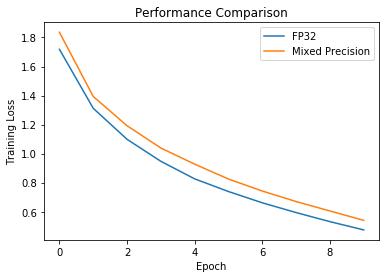

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fp32_results["train_log"].history["loss"], label="FP32")
plt.plot(mp_results["train_log"].history["loss"], label="Mixed Precision")
plt.title("Performance Comparison")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [14]:
speed_up = round(100 * fp32_results["train_time"]/mp_results["train_time"], 1)

print("Total speed-up:", speed_up, "%")

Total speed-up: 159.6 %


## Conclusions

* Mixed Precision training provides a significant speed-up over FP32 (single-precision) training
* Switch to using mixed precision by wrapping a `tf.keras.optimizers` Optimizer in `tf.train.experimental.enable_mixed_precision_graph_rewrite()`
